In [5]:
import os
import pandas as pd
import numpy as np
import yaml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Define paths
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
root_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
DATA_DIR = os.path.join(root_dir, "data", "processed")
MODELS_DIR = os.path.join(root_dir, "models")
RESULTS_DIR = os.path.join(root_dir, "results")

# Load config
with open(os.path.join(root_dir, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)

print("✅ Paths set up correctly.")


✅ Paths set up correctly.


In [6]:
# Load preprocessed dataset
data_path = os.path.join(DATA_DIR, "sample_preprocessed.csv")
df = pd.read_csv(data_path)
print("✅ Loaded preprocessed data:", df.shape)

# Drop non-numeric columns (if any)
non_numeric_cols = df.select_dtypes(exclude=["number"]).columns
if len(non_numeric_cols) > 0:
    print(f"⚠ Dropping non-numeric columns: {list(non_numeric_cols)}")
    df = df.drop(columns=non_numeric_cols)

# Extract features and target
target_col = config["data"]["target"]
X = df.drop(columns=[target_col])
y = pd.Categorical(df[target_col]).codes

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


✅ Loaded preprocessed data: (100000, 72)
⚠ Dropping non-numeric columns: ['Source_File']
Train shape: (70000, 70)  Test shape: (30000, 70)


In [7]:
# Compute balanced class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print("⚖ Computed class weights:", class_weights)

# Train model with class weights
rf_weighted = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight=class_weights, n_jobs=-1
)
rf_weighted.fit(X_train, y_train)
y_pred_weighted = rf_weighted.predict(X_test)

report_weighted = classification_report(y_test, y_pred_weighted, output_dict=True)
print("✅ Weighted model trained.")


⚖ Computed class weights: {np.int8(0): np.float64(0.09959082398602313), np.int8(1): np.float64(114.37908496732027), np.int8(2): np.float64(1.6781741465285769), np.int8(3): np.float64(20.539906103286384), np.int8(4): np.float64(1.2604436761740132), np.int8(5): np.float64(44.87179487179487), np.int8(6): np.float64(40.229885057471265), np.int8(7): np.float64(32.588454376163874), np.int8(9): np.float64(2.4265113699389906), np.int8(10): np.float64(74.78632478632478), np.int8(11): np.float64(153.50877192982455), np.int8(12): np.float64(416.6666666666667)}
✅ Weighted model trained.


C:\Users\bhand\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bhand\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bhand\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [8]:
# Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("✅ Applied SMOTE:", X_train_sm.shape)

# Train RandomForest on SMOTE data
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_smote.fit(X_train_sm, y_train_sm)
y_pred_smote = rf_smote.predict(X_test)

report_smote = classification_report(y_test, y_pred_smote, output_dict=True)
print("✅ SMOTE model trained.")


✅ Applied SMOTE: (702876, 70)
✅ SMOTE model trained.


C:\Users\bhand\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bhand\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bhand\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [9]:
mitigation_dir = os.path.join(RESULTS_DIR, "mitigation")
os.makedirs(mitigation_dir, exist_ok=True)

pd.DataFrame(report_weighted).transpose().to_csv(os.path.join(mitigation_dir, "weighted_model.csv"))
pd.DataFrame(report_smote).transpose().to_csv(os.path.join(mitigation_dir, "smote_model.csv"))

print("✅ Saved mitigation results to:", mitigation_dir)

✅ Saved mitigation results to: C:\Users\bhand\ids-bias-project\results\mitigation


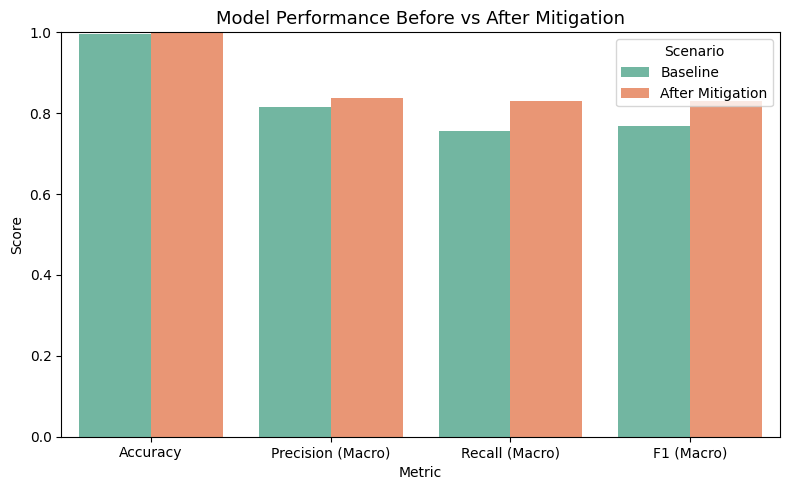

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example mock results — replace with actual metrics_df from baseline and mitigation
baseline_results = {
    'accuracy': 0.9968666666666667,
    'precision_macro': 0.8157113930236599,
    'recall_macro': 0.7565230429298566,
    'f1_macro': 0.7687040298449314
}

mitigation_results = {
    'accuracy': 0.9973666666666666,
    'precision_macro': 0.8375175670570816,
    'recall_macro': 0.8310834524167354,
    'f1_macro': 0.82987163302072978
}

# Combine for visualization
metrics_df = pd.DataFrame([
    {"Metric": "Accuracy", "Score": baseline_results['accuracy'], "Scenario": "Baseline"},
    {"Metric": "Precision (Macro)", "Score": baseline_results['precision_macro'], "Scenario": "Baseline"},
    {"Metric": "Recall (Macro)", "Score": baseline_results['recall_macro'], "Scenario": "Baseline"},
    {"Metric": "F1 (Macro)", "Score": baseline_results['f1_macro'], "Scenario": "Baseline"},
    {"Metric": "Accuracy", "Score": mitigation_results['accuracy'], "Scenario": "After Mitigation"},
    {"Metric": "Precision (Macro)", "Score": mitigation_results['precision_macro'], "Scenario": "After Mitigation"},
    {"Metric": "Recall (Macro)", "Score": mitigation_results['recall_macro'], "Scenario": "After Mitigation"},
    {"Metric": "F1 (Macro)", "Score": mitigation_results['f1_macro'], "Scenario": "After Mitigation"},
])

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x="Metric", y="Score", hue="Scenario", palette="Set2")
plt.title("Model Performance Before vs After Mitigation", fontsize=13)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()